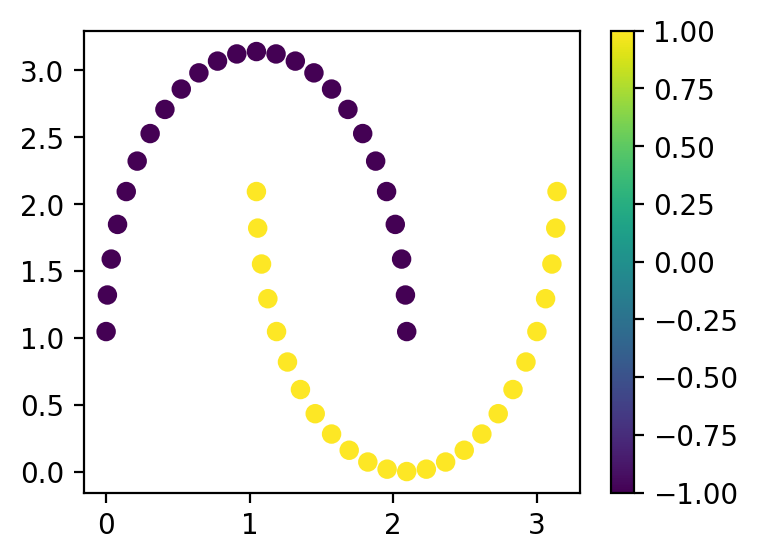

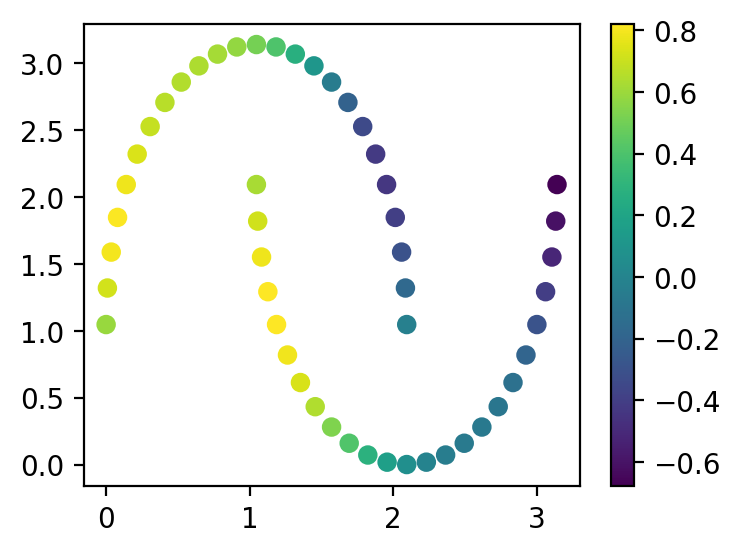

KeyboardInterrupt: 

In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import make_moons

# Load the dataset
x, y = make_moons(n_samples=50)

# Normalize the input data to the interval [0, pi]
def normalize(x):
    """
    Normalizes the input data to the interval [0, pi]
    """
    min_ = x.min()
    max_ = x.max()
    return np.pi * (x - min_) / (max_ - min_)

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])

# Convert the labels to -1 and 1
y = y * 2 - 1

# Plot the dataset
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

# Define the quantum device
dev = qml.device("default.qubit", 2)

# Define the encoding function
def encoding(x1, x2):
    """
    Encodes the input data into a quantum state
    """
    qml.RY(x1, wires=0)
    qml.RY(x2, wires=1)
    qml.RZ(x1, wires=0)
    qml.RZ(x2, wires=1)
    qml.CZ(wires=[0, 1])

# Define the variational quantum circuit
def layer(theta):
    """
    Defines a layer of the variational quantum circuit
    """
    qml.Rot(theta[0, 0], theta[0, 1], theta[0, 2], wires=0)
    qml.Rot(theta[1, 0], theta[1, 1], theta[1, 2], wires=1)
    qml.CZ(wires=[0, 1])

@qml.qnode(dev) 
def node(x1, x2, q):
    """
    Defines the quantum node that takes the input data and the variational parameters as input
    """
    encoding(x1, x2)
    for q_ in q:
        layer(q_)

    return qml.expval(qml.PauliZ(0) @ qml.PauliY(1))

# Define the function that applies the quantum node to the input data
def apply_node(x, q):
    """
    Applies the quantum node to the input data
    """
    res = []

    for x_ in x:
        vqc_output = node(x_[0], x_[1], q[0])
        res.append(vqc_output + q[1])

    return res

# Initialize the variational parameters
np.random.seed(42)
q = [list(np.random.uniform(-np.pi, np.pi, size=(4, 2, 3))), 0.0]

# Plot the dataset with the predictions of the quantum node
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()
def acc(q, x, y): #Поэтому для оценки модели в целом мы будем использовать точность(каво нахуй?)
    preds = np.sign(apply_node(x, q))
    res = 0
    for p_, y_ in zip(preds, y):
        if np.abs(y_ - p_) <= 1e-2:
            res += 1

    return res / y.shape[0]
# Define the cost function
def cost(q, x, y):
    """
    Defines the cost function that measures the difference between the predictions of the quantum node and the true labels
    """
    preds = np.array(apply_node(x, q))
    return np.mean(np.square(preds - y))

# Define the optimizer
opt = qml.optimize.GradientDescentOptimizer(stepsize=0.05)

# Train the variational quantum classifier
acc_ = []
cost_ = []
ii = []
for i in range(75):
    batch = np.random.randint(0, len(x), (10,))
    x_batch = x[batch, :]
    y_batch = y[batch]
    q = opt.step(lambda q_: cost(q_, x_batch, y_batch), q)

    if i % 5 == 0:
        ii.append(i)
        acc_.append(acc(q, x, y))
        cost_.append(cost(q, x, y))

# Plot the accuracy and cost during training
f, ax = plt.subplots(2, figsize=(8, 6), sharex=True)
ax[0].plot(ii, acc_, ".-")
ax[0].set_title("Accuracy")
ax[1].plot(ii, cost_, ".-")
ax[1].set_title("Cost")
plt.show()

# Plot the dataset with the predictions of the trained quantum node
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()